In [1]:
import matplotlib.image as mpimg
import glob
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2
from skimage.feature import hog
import time
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from moviepy.editor import VideoFileClip
from scipy.ndimage.measurements import label
from collections import deque

%matplotlib inline

######################

color_space = 'YUV' #  RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9 # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 16  # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()

######################

#Extract the HOG features

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

######################

#Extract binned color features

def bin_spatial(img,size=spatial_size):    
    
    color1 = cv2.resize(img[:,:,0] , size).ravel()
    color2 = cv2.resize(img[:,:,1] , size).ravel()
    color3 = cv2.resize(img[:,:,2] , size).ravel()
    return np.hstack((color1,color2,color3))

######################

#Extract histogram of colors

def color_hist(img, nbins=hist_bins, bins_range=(0, 256)):

    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)

    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features
    
######################

#Combine the 3 types of features and return the final features for all the input images

def extract_features(imgs, color_space = color_space, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat):

    features = []
    for file in imgs:
        file_features = []
        image = mpimg.imread(file)
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      
            
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
                        
        if hist_feat == True:
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
                
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))

    return features    

######################

#Calculate the sliding windows coordinates and return a set of sliding windows of specific size

def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):

    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = 1280 #img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = 720 #img.shape[0]

    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]

    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))

    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1

    window_list = []

    for ys in range(ny_windows):
        for xs in range(nx_windows):
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            window_list.append(((startx, starty), (endx, endy)))

    return window_list

######################

#Draw the input boxes on an image

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    
    imcopy = np.copy(img)
    
    for bbox in bboxes:
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return imcopy

######################

#Extract the combined features for a single image

def single_img_features(img, color_space = color_space, spatial_size = spatial_size,
                        hist_bins = hist_bins, orient = orient, 
                        pix_per_cell = pix_per_cell, cell_per_block = cell_per_block, 
                        hog_channel = hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat):    

    img_features = []

    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      

    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        img_features.append(spatial_features)
            
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        img_features.append(hist_features)

    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)

        img_features.append(hog_features)

    return np.concatenate(img_features)

######################

#Search the input image for the imput wndows and apply the image to the classifier. 
#Normalize the features. If the classifier detects a car, add the window to output list of windows

def search_windows(img, windows, clf, scaler, color_space = color_space, 
                    spatial_size = spatial_size, hist_bins = hist_bins, 
                    hist_range=(0, 256), orient = orient, 
                    pix_per_cell = pix_per_cell, cell_per_block = cell_per_block, 
                    hog_channel = hog_channel, spatial_feat = spatial_feat, 
                    hist_feat = hist_feat, hog_feat = hog_feat):

    on_windows = []

    for window in windows:

        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      

        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        
        #####
        features[np.isnan(features)] = 0
                               
        test_features = scaler.transform(np.array(features).reshape(1, -1))        
        prediction = clf.predict(test_features)        
        if prediction == 1:
            on_windows.append(window)
    return on_windows

In [2]:
#Get all the file names for cars and non-cars

vehicle_images = glob.glob('./vehicles/*/*.png')
non_vehicle_images = glob.glob('./non-vehicles/*/*.png')
cars = []
notcars = []

for image in vehicle_images:   
    cars.append(image)
    
for image in non_vehicle_images:   
    notcars.append(image)    
    
print("Number of cars:" ,str(len(cars)) )    
print("Number of non-cars:" , str(len(notcars)))

Number of cars: 8792
Number of non-cars: 8968


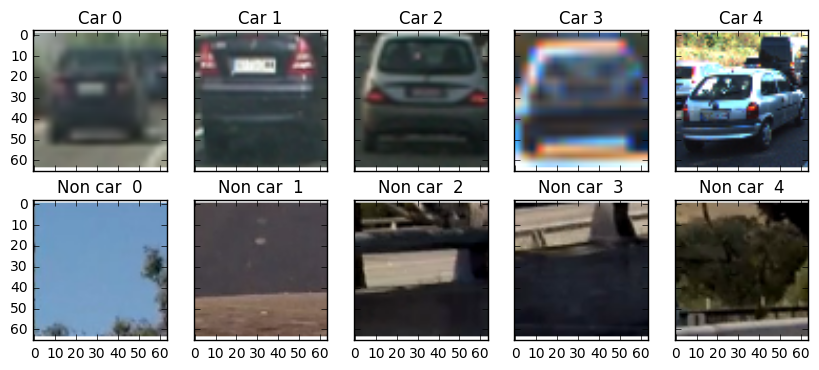

In [3]:
#Draw sample images of cars and non cars

f1 , AXS1 = plt.subplots(2, 5, sharex='col', sharey='row' ,figsize=(10,4))
for n in range(0,5):    
    car1 = mpimg.imread(vehicle_images[n*1001])
    AXS1[0][n].imshow(car1) 
    AXS1[0][n].set_title("Car " + str(n))
    non_car1 = mpimg.imread(non_vehicle_images[n*1001])
    AXS1[1][n].imshow(non_car1) 
    AXS1[1][n].set_title("Non car  " + str(n))
    


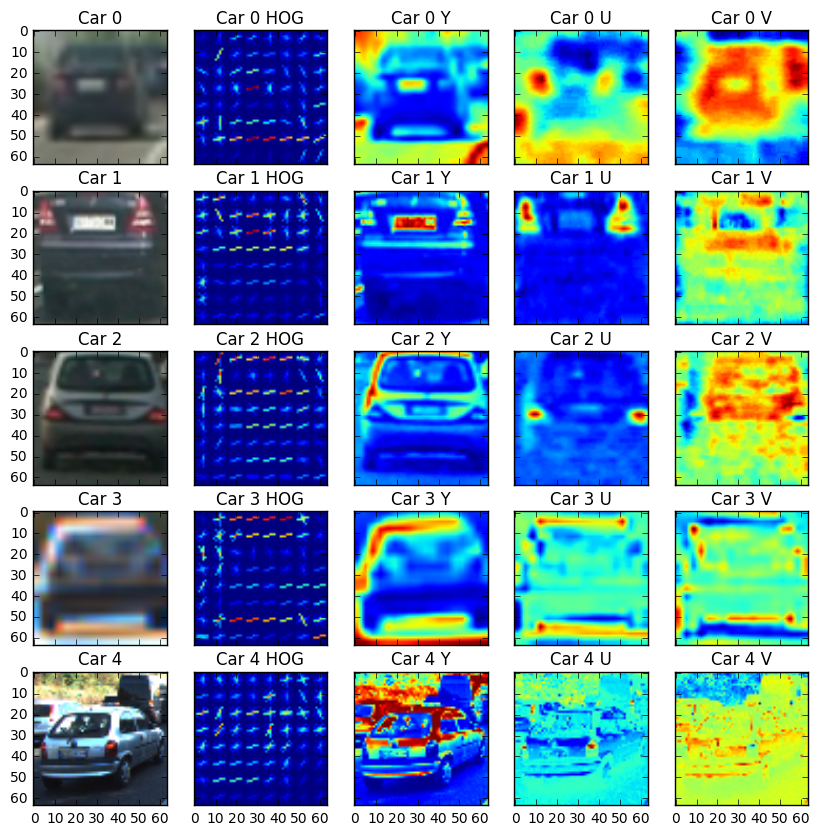

In [4]:
#Draw HOG and channels U,V and W for each sample images

f2 , AXS2 = plt.subplots(5, 5, sharex='col', sharey='row' ,figsize=(10,10))

for n in range(0,5):
    
    car1 = mpimg.imread(vehicle_images[n*1001])
    AXS2[n][0].imshow(car1) 
    AXS2[n][0].set_title("Car " + str(n))

    f, hog1 = get_hog_features(car1[:,:,0], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
    AXS2[n][1].imshow (hog1)
    AXS2[n][1].set_title("Car " + str(n) + " HOG")

    car1_yuv = cv2.cvtColor(car1, cv2.COLOR_RGB2YUV)
    color1_yuv = cv2.resize(car1_yuv[:,:,0] , (64,64))
    AXS2[n][2].imshow (color1_yuv)
    AXS2[n][2].set_title("Car " + str(n) + " Y")

    color2_yuv = cv2.resize(car1_yuv[:,:,1] , (64,64))
    AXS2[n][3].imshow (color2_yuv)
    AXS2[n][3].set_title("Car " + str(n) + " U")

    color3_yuv = cv2.resize(car1_yuv[:,:,2] , (64,64))
    AXS2[n][4].imshow (color3_yuv)
    AXS2[n][4].set_title("Car " + str(n) + " V")

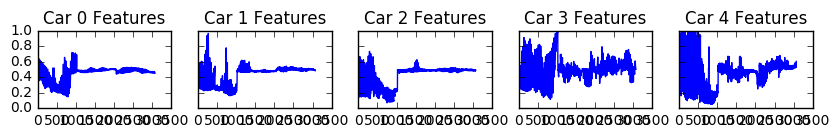

In [5]:
#Plot Spatially Binned Features for sample images

f3 , AXS3 = plt.subplots(1, 5, sharex='col', sharey='row' ,figsize=(10,1))

for n in range(0,5):
    car1 = mpimg.imread(vehicle_images[n*1001])    
    bs = bin_spatial(cv2.cvtColor(car1, cv2.COLOR_RGB2YUV), size=(32, 32))
    AXS3[n].plot(bs)
    AXS3[n].set_title("Car " + str(n) + " Features")

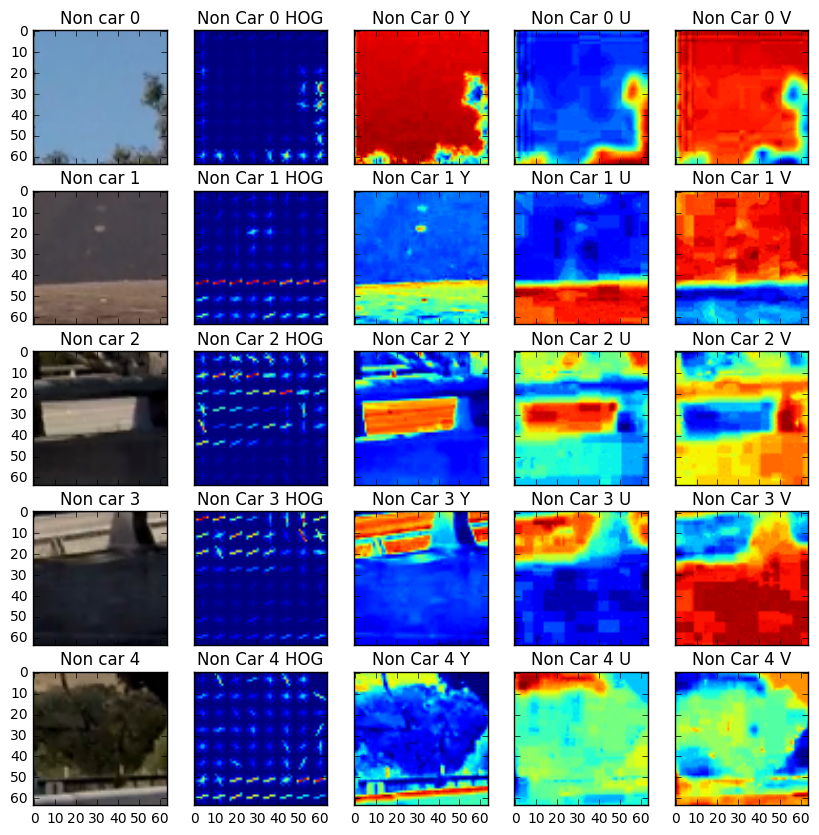

In [6]:
#Draw HOG and channels U,V and W for each sample images

f4 , AXS4 = plt.subplots(5, 5, sharex='col', sharey='row' ,figsize=(10,10))

for n in range(0,5):
    
    non_car1 = mpimg.imread(non_vehicle_images[n*1001])
    AXS4[n][0].imshow(non_car1) 
    AXS4[n][0].set_title("Non car " + str(n))

    f, hog1 = get_hog_features(non_car1[:,:,0], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
    AXS4[n][1].imshow (hog1)
    AXS4[n][1].set_title("Non Car " + str(n) + " HOG")

    non_car1_yuv = cv2.cvtColor(non_car1, cv2.COLOR_RGB2YUV)
    color1_yuv = cv2.resize(non_car1_yuv[:,:,0] , (64,64))
    AXS4[n][2].imshow ( color1_yuv)
    AXS4[n][2].set_title("Non Car " + str(n) + " Y")

    color2_yuv = cv2.resize(non_car1_yuv[:,:,1] , (64,64))
    AXS4[n][3].imshow ( color2_yuv)
    AXS4[n][3].set_title("Non Car " + str(n) + " U")

    color3_yuv = cv2.resize(non_car1_yuv[:,:,2] , (64,64))
    AXS4[n][4].imshow ( color3_yuv)
    AXS4[n][4].set_title("Non Car " + str(n) + " V")


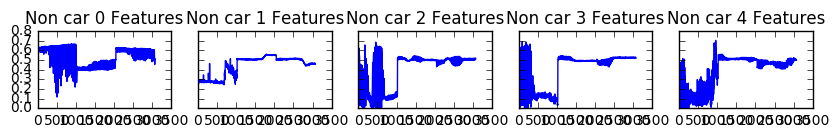

In [ ]:
#Plot Spatially Binned Features for sample images
f5 , AXS5 = plt.subplots(1, 5, sharex='col', sharey='row' ,figsize=(10,1))

for n in range(0,5):
    non_car1 = mpimg.imread(non_vehicle_images[n*1001])    
    bs = bin_spatial(cv2.cvtColor(non_car1, cv2.COLOR_RGB2YUV), size=(32, 32))
    AXS5[n].plot(bs)
    AXS5[n].set_title("Non car " + str(n) + " Features")

In [ ]:
#Extract car and non car features

t=time.time()
car_features = extract_features(cars, color_space=color_space, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel,                               
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat )


t2 = time.time()

print(round(t2-t, 2), 'Seconds to extract features...')
print("Car features shape:" , np.array(car_features).shape)
print("Non car features shape:" ,np.array(notcar_features).shape)

In [ ]:
#Prepare the data and apply it to classifier

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)   

######
X[np.isnan(X)] = 0
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

# Use a linear SVC 
svc = LinearSVC()

# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

In [ ]:
#Function to create heatmap, apply threshold and draw the boxes on an image

def add_heat(heatmap, bbox_list):
    for box in bbox_list:
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap

def apply_threshold(heatmap, threshold):
    heatmap[heatmap <= threshold] = 0
    return heatmap

def draw_labeled_bboxes(img, labels):
    for car_number in range(1, labels[1]+1):
        nonzero = (labels[0] == car_number).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        cv2.rectangle(img, bbox[0], bbox[1], (255,0,0), 6)
    return img


def get_labeled_bboxes(labels):
    boxes = []
    for car_number in range(1, labels[1]+1):
        nonzero = (labels[0] == car_number).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        
        boxes.append( (bbox[0],bbox[1]) )

    return boxes

#Function to generate windows of different sizes
def get_all_windows():
    
    windows = []
    
    windows0 = slide_window(image, x_start_stop=[None, None], y_start_stop=[400,656], 
                    xy_window=(64, 64), xy_overlap=(0.75,0.75))
    
    windows1 = slide_window(image, x_start_stop=[None, None], y_start_stop=[400,656], 
                    xy_window=(96, 96), xy_overlap=(0.75, 0.75))

    windows2 = slide_window(image, x_start_stop=[None, None], y_start_stop=[400,656], 
                    xy_window=(128, 128), xy_overlap=(0.75, 0.75))
        
    windows5 = slide_window(image, x_start_stop=[None, None], y_start_stop=[400,656], 
                    xy_window=(192, 192), xy_overlap=(0.75, 0.75))

    windows.extend(windows0)
    windows.extend(windows1)
    windows.extend(windows2)
    windows.extend(windows5)
    
    return windows
    

In [ ]:
#Draw all the windows and print the number of them

image = mpimg.imread('./x_images/1.jpg')

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)

image = image.astype(np.float32)/255

draw_image = np.copy(image)

windows = get_all_windows()
print("Number of windows = ",len(windows))

all_window_img = draw_boxes(draw_image, windows, color=(60, 0, 0), thick=6) 
plt.imshow(all_window_img)

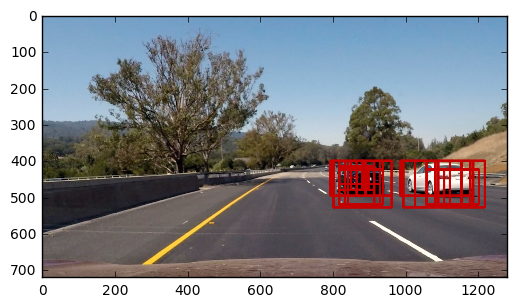

In [12]:
#Find the hot windows among all the windows and draw them
hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)   


window_img = draw_boxes(draw_image, hot_windows, color=(60, 0, 0), thick=6)                    

plt.imshow(window_img)

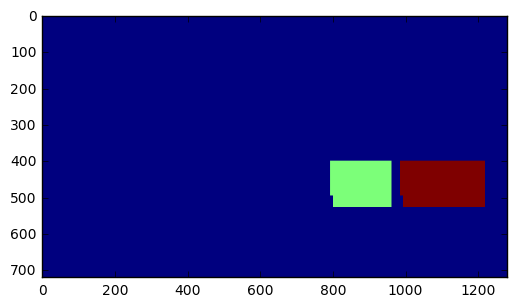

In [13]:
#Generate the heat map and draw it
heat = np.zeros_like(window_img[:,:,0]).astype(np.float)
hhh = add_heat(heat,hot_windows)
hhh = apply_threshold(heat,0)

labels = label(hhh)

labeled_image = draw_labeled_bboxes(np.copy(draw_image), labels)

plt.imshow(labels[0])

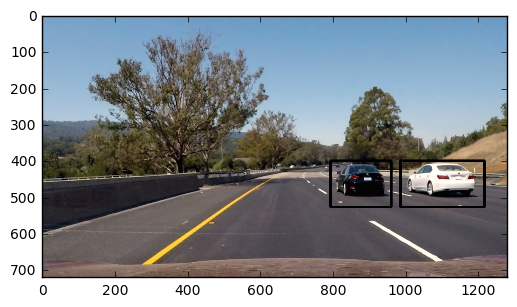

In [14]:
#Draw the imafe combined with hetmap windows
plt.imshow(labeled_image)

In [15]:
#Create a Queue to hold last q_max of frames, to be used to average the boxes for the frames
heat_threshold = 0
q_max =10
q = deque(maxlen=q_max)
frame_threshold = 3

#Function to compare 2 boxes and return True if they are close enough

def compare_boxes(b1,b2):
    cx1 = (b1[0][0] + b1[1][0]) / 2
    cy1 = (b1[0][1] + b1[1][1]) / 2
    
    cx2 = (b2[0][0] + b2[1][0]) / 2
    cy2 = (b2[0][1] + b2[1][1]) / 2
    
    d = math.sqrt( (cx1-cx2) ** 2  + (cy1-cy2) ** 2  )
    #thr = .5 * (b1[1][0] - b1[0][0])
    thr = 100
    if d < thr :
        return True
    
    return False

In [16]:
#Combine all the above steps to create a pipeline
#Get the image, get all the windows, search the imgae for the windows,
#Create the heatmap, and find the final windows for the current image.
#Then take an average for all the windows which are near enough to this window and draw it
import math

def pipeline(image):   
    
    heat_map1 = np.zeros_like(image[:,:,0]).astype(np.float)        
    draw_image = np.copy(image)
                   
    image = image.astype(np.float32)/255
    
    hhh = None
    windows = get_all_windows()        

    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)   
        
    heats1 = add_heat(heat_map1,hot_windows)
    heats1 = apply_threshold(heat_map1,heat_threshold)
    labels1 = label(heats1)
        
    boxes1 = get_labeled_bboxes(labels1)
    
    final_windows = []
    
    for box in boxes1:
        current_batch = []
        for bb in q:
            for b in bb:                                                
                if compare_boxes(box,b) == True:
                    current_batch.append(b)
                    
                    
        if len(current_batch) > frame_threshold:   
            length = len(current_batch)
            sum_x1 = 0
            sum_y1 = 0
            sum_x2 = 0
            sum_y2 = 0

            for cb in current_batch:
                sum_x1 += cb[0][0]
                sum_y1 += cb[0][1]
                sum_x2 += cb[1][0]
                sum_y2 += cb[1][1]                            

            final_windows.append( ((int(sum_x1/length),int(sum_y1/length) ) ,  (int(sum_x2/length),int(sum_y2/length) ))  )
           
    for w in final_windows:
        cv2.rectangle(draw_image, w[0] , w[1] , (255,255,255), 6)        
            
    q.append(boxes1)
            
    return draw_image

In [ ]:
project_video_output = 'output.mp4'
clip1 = VideoFileClip("project_video.mp4")
first_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time first_clip.write_videofile(project_video_output, audio=False)

[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing video output.mp4


 11%|█▏        | 144/1261 [20:09<2:48:57,  9.08s/it]